# Import Dependencies

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import scipy.stats as stats
from statistics import mean

import numpy as np
import pandas as pd

import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# place holder in case of wanting to inspect the engine to show properties/ methods
inspector = inspect(engine)
dir(inspector)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_index_sort_exprs',
 '_insp',
 '_reflect_check_constraints',
 '_reflect_col_sequence',
 '_reflect_column',
 '_reflect_fk',
 '_reflect_indexes',
 '_reflect_pk',
 '_reflect_table_comment',
 '_reflect_unique_constraints',
 'bind',
 'default_schema_name',
 'dialect',
 'engine',
 'from_engine',
 'get_check_constraints',
 'get_columns',
 'get_foreign_keys',
 'get_indexes',
 'get_pk_constraint',
 'get_primary_keys',
 'get_schema_names',
 'get_sorted_table_and_fkc_names',
 'get_table_comment',
 'get_table_names',
 'get_table_options',
 'get_temp_table_names',
 'get_temp_view_names',
 'get_unique_constraints',
 'get_view_definiti

In [5]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

# reflect the tables
tables = Base.classes.keys()

In [6]:
# show all of the classes that automap found
tables

['measurement', 'station']

In [7]:
# Save references to each table
station = Base.classes['station']
measurement = Base.classes['measurement']

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
# inspect the measurement table to find column names
dir(measurement)[-10:]

['_sa_decl_prepare',
 '_sa_raise_deferred_config',
 'classes',
 'date',
 'id',
 'metadata',
 'prcp',
 'prepare',
 'station',
 'tobs']

In [10]:
dir(station)[-10:]

['_sa_raise_deferred_config',
 'classes',
 'elevation',
 'id',
 'latitude',
 'longitude',
 'metadata',
 'name',
 'prepare',
 'station']

# Exploratory Climate Analysis

## Precipitation Analysis

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# use timedelta to calculate query_date
prp_tpl = session.query(measurement.date, measurement.prcp).all() # list of tuples
last_date = dt.datetime.strptime(prp_tpl[-1][0], '%Y-%m-%d')
# print(last_date, type(last_date))
# print(prp_tpl[-1][0])
# Calculate the date 1 year ago from the last data point in the database & convert data into dataframe
query_date  = last_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
prp_tpl = session.query(measurement.date, measurement.prcp).filter(measurement.date > query_date).all()

# Save the query results as a Pandas DataFrame
prp_df = pd.DataFrame(prp_tpl,columns=['Date', 'Precipitation'])

# set the index to the date column
prp_df.set_index('Date', inplace=True)

# Sort the dataframe by date
prp_df.sort_index(inplace=True)
prp_df

,Precipitation
Date,
2016-08-24,0.08
2016-08-24,NaN
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15
...,...
2017-08-22,0.00
2017-08-23,0.08
2017-08-23,0.00


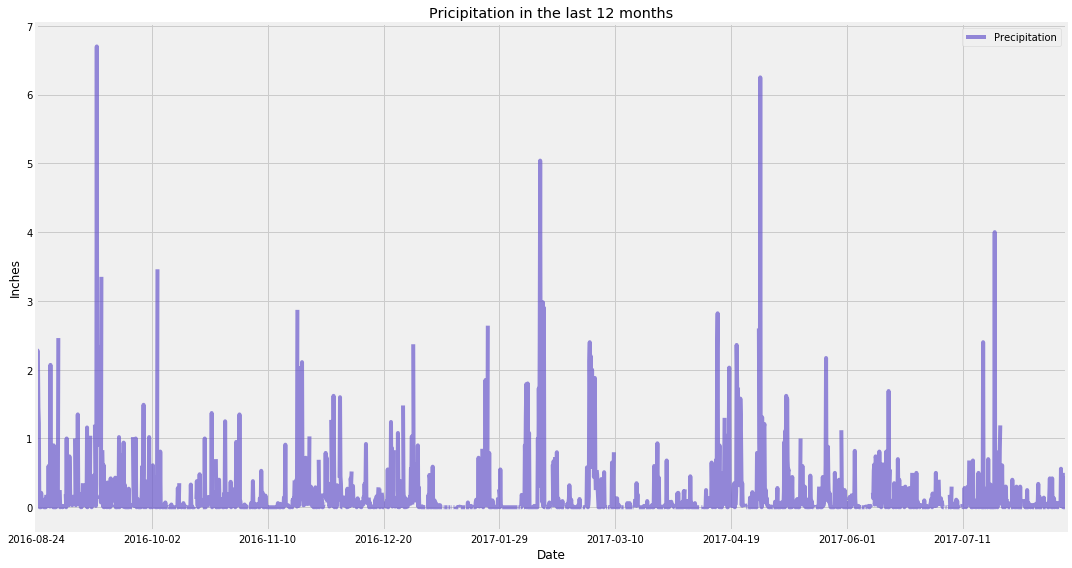

In [39]:
# Use Pandas Plotting with Matplotlib to plot the data
prp_df.plot(figsize=(15,8), rot=0, alpha=0.7, color = 'slateblue')

# use Matplotlib to decorate
plt.title("Pricipitation in the last 12 months") 
plt.xlabel("Date") 
plt.ylabel("Inches")
plt.tight_layout()

# save fig to Images folder
plt.savefig("Images/Precipitation_last1yr.png")

# show all layers on the final charts
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
prp_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Weather Station Analysis

In [14]:
# Design a query to show how many stations are available in this dataset?
print(f'>>There are total \033[1;34m{session.query(station.id).count()}\033[0m stations in the dataset.')

>>There are total 9 stations in the dataset.


In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
prp_station = session.query(measurement.station,func.count(measurement.station))\
                            .group_by(measurement.station)\
                            .order_by(func.count(measurement.station).desc()).all()
# List the stations and the counts in descending order.
pd.DataFrame(prp_station, columns = ['Station ID', 'Datapoint Collected'])

,Station ID,Datapoint Collected
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
# observation : 
    # the most active station is the one with highest row counts, since the list was sorted descending, index = 0 is the top station

top_station_id = prp_station[0][0]
topstation_MINtemp = session.query(func.min(measurement.tobs)).filter_by(station = top_station_id).first()[0]
topstation_AVEtemp = round(session.query(func.avg(measurement.tobs)).filter_by(station = top_station_id).first()[0], 0)
topstation_MAXtemp = session.query(func.max(measurement.tobs)).filter_by(station = top_station_id).first()[0]
print(f'>> Most active station : \033[1;31m{top_station_id}\033[0m\n\
    * Min Temperature : {topstation_MINtemp} deg-F\n\
    * Max Temperature : {topstation_MAXtemp} deg-F\n\
    * Average Temperature : {topstation_AVEtemp} deg-F')


>> Most active station : USC00519281
    * Min Temperature : 54.0 deg-F
    * Max Temperature : 85.0 deg-F
    * Average Temperature : 72.0 deg-F


In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station 

top_station_tobs = session.query(measurement.date, measurement.tobs)\
    .filter(measurement.station == top_station_id)\
    .filter(measurement.date > query_date).all()

# convert to dataframe for plotting
top_station_tobs_df = pd.DataFrame(top_station_tobs, columns=['Date', 'Temperatures'])
top_station_tobs_df.sort_values('Date', inplace=True)
top_station_tobs_df

,Date,Temperatures
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0
...,...,...
346,2017-08-14,77.0
347,2017-08-15,77.0
348,2017-08-16,76.0
349,2017-08-17,76.0


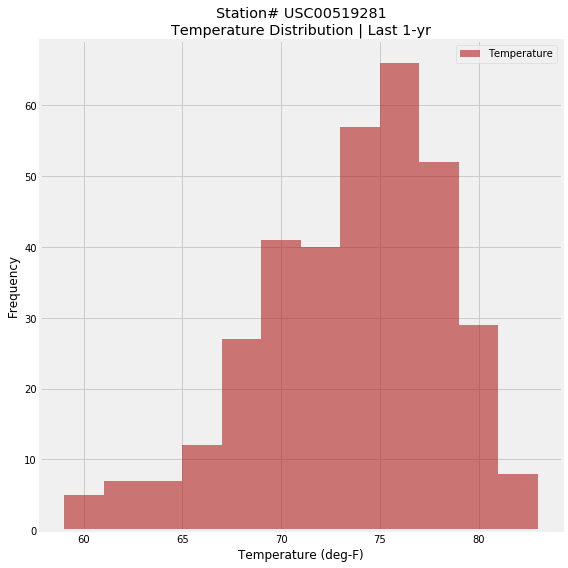

In [38]:
# plot the results as a histogram
top_station_tobs_df.hist(figsize=(8, 8), bins=12, color = 'firebrick', alpha = 0.6)
plt.legend(['Temperature'])
plt.xlabel('Temperature (deg-F)')
plt.ylabel('Frequency')

# I like to build a flexible code where things change when database is changed
# so I create f-string with changeable station name to plot and to export graph
plt.title(f'Station# {top_station_id}\nTemperature Distribution | Last 1-yr')
plt.tight_layout()
plt.savefig(f'Images/{top_station_id}_1yr_Temp.png')
plt.show()

## Bonus Challenge Assignment

### Vacation Trip Temperature Analysis

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).first()



#### SPECIFY VACATION TIME:  


In [20]:
vac_start = '2016-12-15'
vac_end = '2017-1-7'

print(f'>> Vacation Schedule:\n\
    * Start Date : {vac_start}\n\
    * End Date   : {vac_end}')


>> Vacation Schedule:
    * Start Date : 2016-12-15
    * End Date   : 2017-1-7


In [21]:
# calculate the tmin, tavg, and tmax using <calc_temps> function
# for trip using the previous year's data for those same dates.

vac_date = [vac_start, vac_end]
vac_temp = calc_temps(vac_date[0], vac_date[1])
vac_temp

(58.0, 73.95019920318725, 87.0)

In [22]:
# unpack vac_temp
tmin = vac_temp[0]
tavg = vac_temp[1]
tmax = vac_temp[2]

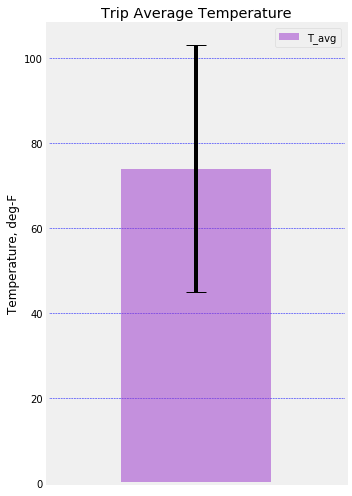

In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
err_temp = tmax - tmin
tavg_df = pd.DataFrame({"T_avg" : [tavg]})
tavg_df.plot(kind='bar', yerr=err_temp, figsize=(5,7), alpha=0.5, color= 'darkorchid', capsize = 10)


# decorate chart with matplotlib
plt.title("Trip Average Temperature")
plt.ylabel("Temperature, deg-F")
plt.xticks([])
plt.grid(color='b', linestyle='--', linewidth=0.5)
plt.tight_layout()

# export chart to image file
plt.savefig("Images/VacTempSum.png")

plt.show()

In [24]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

vac_prcp = session.query(measurement.station, func.sum(measurement.prcp), station.name, station.latitude, station.longitude, station.elevation)\
                                                .filter(measurement.date >= vac_date[0])\
                                                .filter(measurement.date <= vac_date[1])\
                                                .group_by(measurement.station)\
                                                .order_by(func.sum(measurement.prcp).desc())\
                                                .join(station, station.station == measurement.station)\
                                                .all()
vac_prcp
pd.DataFrame(vac_prcp, columns=["ID", 'Precipation', "Name", "Latitude", "Longitude", "Elevation"])

,ID,Precipation,Name,Latitude,Longitude,Elevation
0,USC00516128,79.10,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,USC00519281,46.94,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,USC00513117,37.14,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,USC00519523,28.30,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
4,USC00514830,23.45,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
5,USC00519397,11.05,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
6,USC00517948,3.45,"PEARL CITY, HI US",21.39340,-157.97510,11.9


### Is it true that Hawaii has mild weather all year? 

In [25]:
# Hawaii is reputed to enjoy mild weather all year. True or False?
# Is there a meaningful difference between the temperature in, for example, June and December?

def monthly_ave_temp(month_2digit):
    """Calculate monthly average temperature
    
    Args:
        date (str): A date string in the format '%m'
        
    Returns:
        A list of tuples containing the monthly average t_mo_avg
    
    """
    return session.query(measurement.tobs).filter(func.strftime("%m", measurement.date) == month_2digit).all()

# Identify the average temperature in June at all stations across all available years in the dataset
# Do the same for December temperature.
jun_temp_data = [temp[0] for temp in monthly_ave_temp("06")]
dec_temp_data = [temp[0] for temp in monthly_ave_temp("12")]

# calculate means of Jun and Dec temps:
print(f'{("-")*50}\n>> Average Temps Summary:\n\
        * June: {round(mean(jun_temp_data), 2)} def-F\n\
        * Dec : {round(mean(dec_temp_data), 2)} deg-F \n{("-")*50}')

# Use the t-test to determine whether the difference in the means
print(f'>> Techniques: Un-paired T-test\n\
        * Because 2 populations (data of the entire month) are compared to each other\n\
        * Rather than comparing day by day\n{("-")*50}')
result_tt = stats.ttest_ind(jun_temp_data, dec_temp_data, equal_var=False)
print(f'>> Results:\n\
        * Statistic: {result_tt[0]}\n\
        * P-Value: {result_tt[1]}\n{("-")*50}')

# is statistically significant?
# p-value: accounted for both variance and mean
if result_tt[1] < 0.05:
    print(f'>> Conclusion:\n\
        * Statistically significant difference')
else:
     print(f'>> Conclusion:\n\
        * NOT Statistically significant difference\n{("-")*50}')

--------------------------------------------------
>> Average Temps Summary:
        * June: 74.94 def-F
        * Dec : 71.04 deg-F 
--------------------------------------------------
>> Techniques: Un-paired T-test
        * Because 2 populations (data of the entire month) are compared to each other
        * Rather than comparing day by day
--------------------------------------------------
>> Results:
        * Statistic: 31.355036920962423
        * P-Value: 4.193529835915755e-187
--------------------------------------------------
>> Conclusion:
        * Statistically significant difference


### Daily Temperature Average During Vacation 

In [26]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()

# test daily_normals function
daily_normals("04-07")

[(63.0, 71.10526315789474, 78.0)]

In [27]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
s_date = dt.datetime.strptime(vac_start, '%Y-%m-%d')
e_date = dt.datetime.strptime(vac_end, '%Y-%m-%d')

# create two lists and time step 
vac_date_list = [] # for getting month-date format
vac_d_yr_list = [] # for getting year-month-date format
step = dt.timedelta(days=1)

# loop and find all date range within start and end date
while s_date <= e_date:
        # Stip off the year and save a list of %m-%d strings
        date = dt.datetime.strftime(s_date, "%m-%d")
        d_yr = dt.datetime.strftime(s_date, "%Y-%m-%d")
        vac_date_list.append(date)
        vac_d_yr_list.append(d_yr)
        s_date += step

In [28]:
# Loop through the list of %m-%d strings and calculate the normals for each date
d_norm_tlist = [] #create empty list to hole tuple of temp calculated values
for eaday in vac_date_list:
    d_norm_tlist.append(daily_normals(eaday)[0])

d_norm_tlist
d_norm_df = pd.DataFrame(d_norm_tlist, columns = ["Min Temp", "Avg Temp", "Max Temp"]) 
d_norm_df['Date'] = vac_d_yr_list
d_norm_df = d_norm_df[["Date", "Min Temp", "Avg Temp", "Max Temp"]].round(2)

# Convert the 'Date' column into a collection of datetime objects: df.Date
d_norm_df['Date'] = pd.to_datetime(d_norm_df['Date'])

# Set the index to be the converted 'Date' column
d_norm_df.set_index('Date', inplace=True)
d_norm_df

,Min Temp,Avg Temp,Max Temp
Date,,,
2016-12-15,62.0,71.34,79.0
2016-12-16,60.0,69.62,82.0
2016-12-17,63.0,70.64,77.0
2016-12-18,63.0,71.28,77.0
2016-12-19,67.0,72.00,78.0
2016-12-20,65.0,72.91,81.0
2016-12-21,67.0,72.14,78.0
2016-12-22,67.0,71.13,77.0
2016-12-23,61.0,70.35,78.0


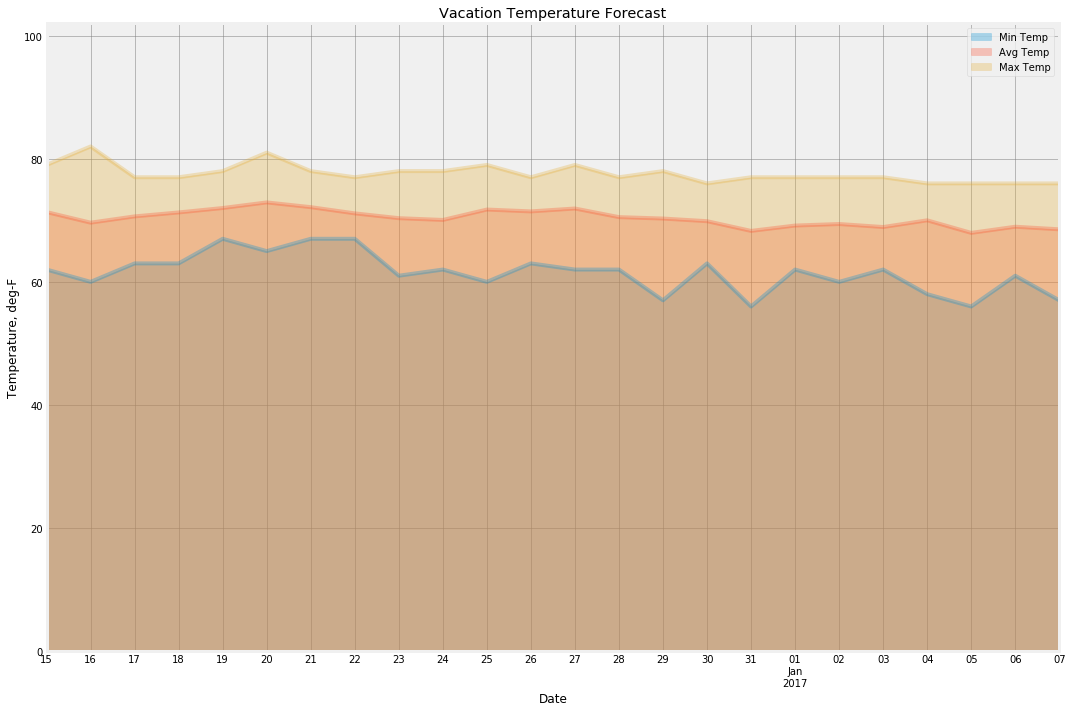

In [37]:
# Plot the daily normals as an area plot with `stacked=False`
d_norm_df.plot.area(stacked=False, rot=0,figsize=(15, 10), alpha = 0.3)

# use Matplotlib to decorate
plt.ylim(0, max(d_norm_df['Max Temp'] + 20))
plt.ylabel("Temperature, deg-F")
plt.legend(loc="best")
plt.title("Vacation Temperature Forecast")
plt.grid(color='gray', linestyle='-', linewidth=0.5, which='both', axis = 'both')
plt.tight_layout()

# save image to file
plt.savefig("Images/VacTempFrCst.png")

plt.show()